### **Importing Packages**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### **Loading and Examining the Data**

In [3]:
# Load the actual path to your CSV file in Google Drive
file_path = ("C:/Users/Lenovo/Downloads/Warehouse_and_Retail_Sales.csv")
data = pd.read_csv(file_path)  # Assign the DataFrame to df

In [4]:
# Display the first few rows of the dataset
print("Initial Data Preview:")
print(data.head())

Initial Data Preview:
   YEAR  MONTH                           SUPPLIER ITEM CODE  \
0  2020      1  REPUBLIC NATIONAL DISTRIBUTING CO    100009   
1  2020      1                          PWSWN INC    100024   
2  2020      1            RELIABLE CHURCHILL LLLP      1001   
3  2020      1          LANTERNA DISTRIBUTORS INC    100145   
4  2020      1               DIONYSOS IMPORTS INC    100293   

                      ITEM DESCRIPTION ITEM TYPE  RETAIL SALES  \
0                  BOOTLEG RED - 750ML      WINE          0.00   
1            MOMENT DE PLAISIR - 750ML      WINE          0.00   
2  S SMITH ORGANIC PEAR CIDER - 18.7OZ      BEER          0.00   
3        SCHLINK HAUS KABINETT - 750ML      WINE          0.00   
4       SANTORINI GAVALA WHITE - 750ML      WINE          0.82   

   RETAIL TRANSFERS  WAREHOUSE SALES  
0               0.0              2.0  
1               1.0              4.0  
2               0.0              1.0  
3               0.0              1.0  
4      

In [5]:
# Basic information about the dataset
print("\nData Information:")
print(data.info())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB
None


In [6]:
# Summary statistics of the dataset
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
                YEAR          MONTH   RETAIL SALES  RETAIL TRANSFERS  \
count  307645.000000  307645.000000  307642.000000     307645.000000   
mean     2018.438525       6.423862       7.024071          6.936465   
std         1.083061       3.461812      30.986238         30.237195   
min      2017.000000       1.000000      -6.490000        -38.490000   
25%      2017.000000       3.000000       0.000000          0.000000   
50%      2019.000000       7.000000       0.320000          0.000000   
75%      2019.000000       9.000000       3.267500          3.000000   
max      2020.000000      12.000000    2739.000000       1990.830000   

       WAREHOUSE SALES  
count    307645.000000  
mean         25.294597  
std         249.916798  
min       -7800.000000  
25%           0.000000  
50%           1.000000  
75%           5.000000  
max       18317.000000  


### **Handling Missing Values**

**Using IQR for outlier detection and imputation.**

In [7]:
# Handling missing values
from sklearn.impute import SimpleImputer

# Checking for missing values
missing_values = data.isnull().sum()
print("\nMissing Values Before Imputation:")
print(missing_values[missing_values > 0])

# For categorical columns, use the most frequent value to fill missing values
cat_imputer = SimpleImputer(strategy='most_frequent')

# For numerical columns, use the mean to fill missing values
num_imputer = SimpleImputer(strategy='mean')

# Reshape the output of fit_transform to be 1D
data['SUPPLIER'] = cat_imputer.fit_transform(data[['SUPPLIER']]).ravel()
data['ITEM TYPE'] = cat_imputer.fit_transform(data[['ITEM TYPE']]).ravel()
data[['RETAIL SALES']] = num_imputer.fit_transform(data[['RETAIL SALES']])

# Convert ITEM CODE to numeric
data['ITEM CODE'] = pd.to_numeric(data['ITEM CODE'], errors='coerce')

# Check again for any missing values
print("\nMissing Values After Imputation:")
print(data.isnull().sum())


Missing Values Before Imputation:
SUPPLIER        167
ITEM TYPE         1
RETAIL SALES      3
dtype: int64

Missing Values After Imputation:
YEAR                 0
MONTH                0
SUPPLIER             0
ITEM CODE           54
ITEM DESCRIPTION     0
ITEM TYPE            0
RETAIL SALES         0
RETAIL TRANSFERS     0
WAREHOUSE SALES      0
dtype: int64


### **Removing Outliers using IQR**

In [8]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    return df.loc[filter]

# Apply IQR outlier removal
data = remove_outliers_iqr(data, 'RETAIL SALES')
data = remove_outliers_iqr(data, 'RETAIL TRANSFERS')
data = remove_outliers_iqr(data, 'WAREHOUSE SALES')

### **Preprocessing**

**Encoding categorical variables and scaling features.**

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical variables
label_encoder = LabelEncoder()
data['SUPPLIER'] = label_encoder.fit_transform(data['SUPPLIER'])
data['ITEM DESCRIPTION'] = label_encoder.fit_transform(data['ITEM DESCRIPTION'])
data['ITEM TYPE'] = label_encoder.fit_transform(data['ITEM TYPE'])

# Select features for clustering
features = data[['YEAR', 'MONTH', 'SUPPLIER', 'ITEM CODE', 'ITEM DESCRIPTION', 'ITEM TYPE',
                 'RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']]

# Fill NaN values in the ITEM CODE column with the mean of that column
features['ITEM CODE'].fillna(features['ITEM CODE'].mean(), inplace=True)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

### **Exploratory Data Analysis (EDA)**

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

### **Visualizing the distribution of sales data**

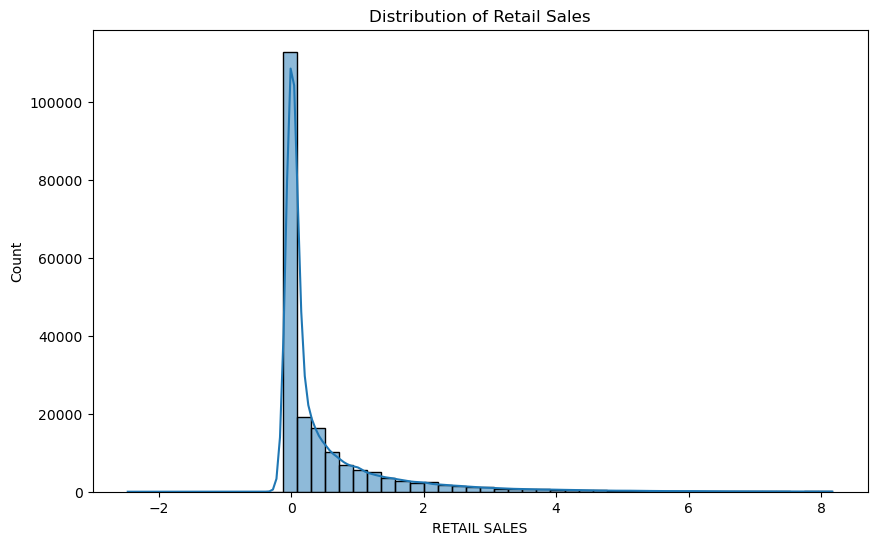

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data['RETAIL SALES'], bins=50, kde=True)
plt.title('Distribution of Retail Sales')
plt.show()

### **correlation heatmap**

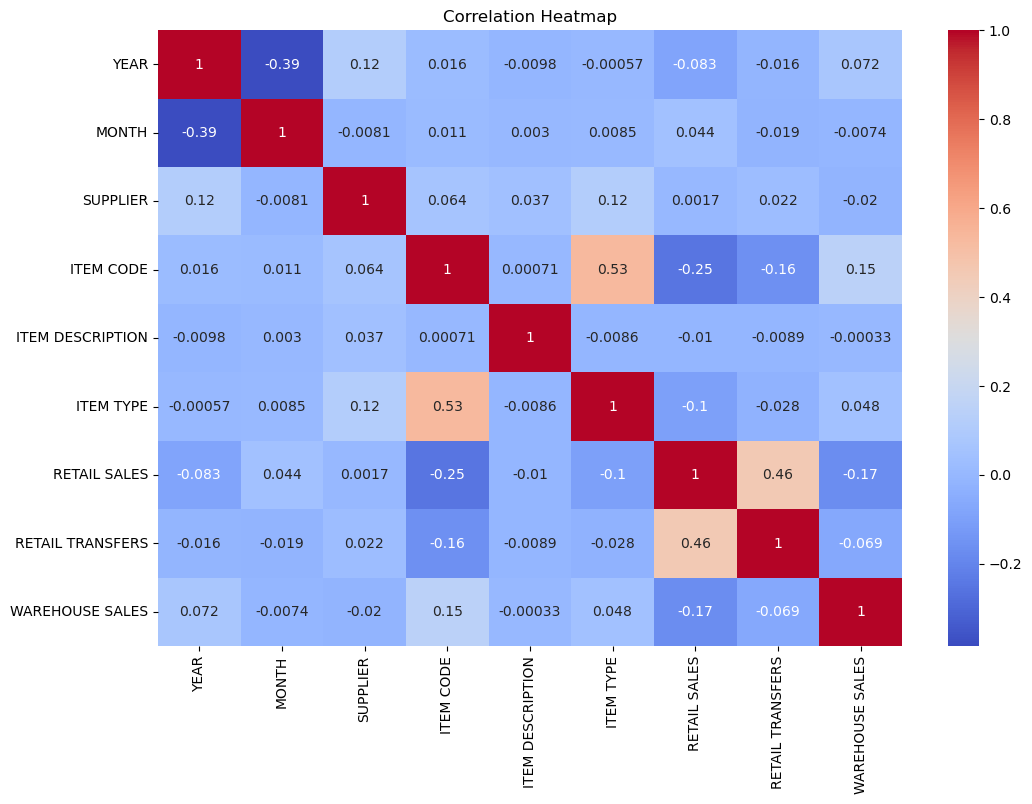

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### **Splitting the Data into Training and Test Sets**

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test = train_test_split(scaled_data, test_size=0.3, random_state=42)


### **Preprocessing and Clustering**

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

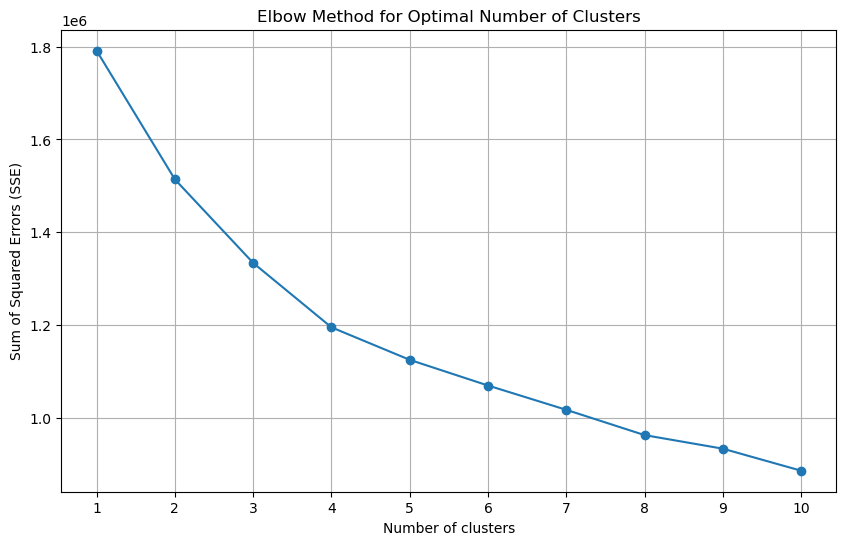

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Encode categorical variables
label_encoder = LabelEncoder()
data['SUPPLIER'] = label_encoder.fit_transform(data['SUPPLIER'])
data['ITEM DESCRIPTION'] = label_encoder.fit_transform(data['ITEM DESCRIPTION'])
data['ITEM TYPE'] = label_encoder.fit_transform(data['ITEM TYPE'])

# Select features for clustering
features = data[['YEAR', 'MONTH', 'SUPPLIER', 'ITEM CODE', 'ITEM DESCRIPTION', 'ITEM TYPE',
                 'RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']]

# Fill NaN values in the ITEM CODE column with the mean of that column
features['ITEM CODE'].fillna(features['ITEM CODE'].mean(), inplace=True)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# Determine the optimal number of clusters using the Elbow Method
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Choose the optimal number of clusters based on the Elbow Method
optimal_k = 3

# Fit the K-Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

# Evaluate the model using the Silhouette Score
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f'Silhouette Score for {optimal_k} clusters: {silhouette_avg}')

### **Predict Clusters and Visualize using PCA**

In [ ]:
# Visualizing clusters in a 2D space using PCA
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
data['PC1'] = principal_components[:, 0]
data['PC2'] = principal_components[:, 1]

# Predict clusters for the entire dataset
data['Cluster'] = kmeans.predict(scaled_data)

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data, palette='Set1')
plt.title('Product Clusters')
plt.show()

### **Comprehensive Product Clusters Report**

In [1]:
# Grouping by clusters to analyze cluster characteristics
cluster_summary = data.groupby('Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

# Save the cluster report to a CSV file
cluster_summary.to_csv("C:/Users/Lenovo/Downloads/Warehouse_and_Retail_Sales.csv")

NameError: name 'data' is not defined